In [1]:
import sys
import cv2
import pandas as pd
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from utils.datasets import get_labels
from utils.inference import detect_faces
from utils.inference import draw_text
from utils.inference import draw_bounding_box
from utils.inference import apply_offsets
from utils.inference import load_detection_model
from utils.inference import load_image
from utils.preprocessor import preprocess_input
import os

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

In [3]:
# parameters for loading data and images
image_path = 'fer2013.csv'
detection_model_path = 'haarcascade_frontalface_default.xml'
#emotion_model_path = 'fer2013_big_XCEPTION.54-0.66.hdf5'
emotion_model_path = 'fer2013_mini_XCEPTION.56-0.65.hdf5'
emotion_labels = get_labels('fer2013')
font = cv2.FONT_HERSHEY_SIMPLEX

# hyper-parameters for bounding boxes shape
emotion_offsets = (20, 40)
#emotion_offsets = (0, 0)

In [13]:
data = pd.read_csv(image_path)

In [5]:
labels = pd.get_dummies(data['emotion']).as_matrix()

In [7]:
#new image path
new_img_path = '../../data/TestImgs_48/'

In [5]:
# loading models
face_detection = load_detection_model(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)

# getting input model shapes for inference
emotion_target_size = emotion_classifier.input_shape[1:3]

In [8]:
emotion_classifier.input_shape
emotion_target_size

(64, 64)

In [6]:
data = pd.read_csv(image_path)


In [11]:
data = data.loc[ data['Usage'] == 'PublicTest']
#data = data.loc[data['Usage']=='PrivateTest']

In [16]:
len(data.loc[data['Usage']=='PrivateTest'])

3589

In [11]:
pixels = data['pixels']

In [12]:
face_test = np.array([int(pix) for pix in np.fromstring(pixels.iloc[0], np.uint8, sep=' ')])
face_test = face_test.reshape(48,48)
face_test = cv2.resize(face_test.astype('uint8'), emotion_target_size)

In [13]:
faces = []
for count in range(len(pixels)):
    face = np.array([int(pix) for pix in np.fromstring(pixels.iloc[count], np.uint8, sep=' ')])
    face = face.reshape((48,48))
    face = cv2.resize(face.astype('uint8'), emotion_target_size)
    faces.append(face.astype('float32'))
faces = np.asarray(faces)
emotions = data['emotion']

In [14]:
face1 = np.squeeze(faces[20])
face1 = preprocess_input(face1, True)
face1 = np.expand_dims(face1, 0)
face1 = np.expand_dims(face1, -1)

In [15]:
np.argmax(emotion_classifier.predict(face1))

3

In [16]:
emotions.iloc[1]

5

In [17]:
pred_emotions =[]
for gray_image in faces:
    gray_image = np.squeeze(gray_image)
    gray_image = preprocess_input(gray_image, True)
    gray_image = np.expand_dims(gray_image, 0)
    gray_image = np.expand_dims(gray_image, -1)
    emotion_label_arg = np.argmax(emotion_classifier.predict(gray_image))
    pred_emotions.append(emotion_label_arg)

In [18]:
len(emotions) == len(pred_emotions)

True

In [19]:
acc = 0
for index, pred in enumerate(pred_emotions):
    if emotions.iloc[index] == pred:
        acc  = acc + 1
    else:
        continue
acc = acc/len(emotions)

In [20]:
len(pred_emotions)

3589

In [21]:
#confusion matrix 
# x coordinate are predition emotion)
# y coordiante is truth emotions
confusion_matrix = np.zeros((7,7))

In [22]:
for pred, truth in zip(pred_emotions, emotions):
    confusion_matrix[truth, pred] += 1

In [23]:
confusion_matrix

array([[295.,   8.,  52.,  16.,  60.,   9.,  51.],
       [ 14.,  30.,   6.,   0.,   2.,   1.,   2.],
       [ 86.,   0., 230.,  17.,  96.,  55.,  44.],
       [ 27.,   0.,  17., 764.,  22.,  15.,  34.],
       [ 61.,   4.,  70.,  28., 321.,   5., 105.],
       [ 14.,   0.,  50.,  18.,  12., 312.,  10.],
       [ 35.,   2.,  52.,  32.,  96.,   6., 403.]])

In [24]:
matrix = np.zeros_like(confusion_matrix)

In [25]:
np.sum(confusion_matrix,axis=1)

array([491.,  55., 528., 879., 594., 416., 626.])

In [26]:
for index, i in enumerate(np.sum(confusion_matrix,axis=1)):
    matrix[index,:] = confusion_matrix[index,:]/i

In [27]:
matrix

array([[0.60081466, 0.01629328, 0.10590631, 0.03258656, 0.12219959,
        0.01832994, 0.10386965],
       [0.25454545, 0.54545455, 0.10909091, 0.        , 0.03636364,
        0.01818182, 0.03636364],
       [0.16287879, 0.        , 0.43560606, 0.03219697, 0.18181818,
        0.10416667, 0.08333333],
       [0.03071672, 0.        , 0.01934016, 0.86916951, 0.02502844,
        0.01706485, 0.03868032],
       [0.1026936 , 0.00673401, 0.11784512, 0.04713805, 0.54040404,
        0.00841751, 0.17676768],
       [0.03365385, 0.        , 0.12019231, 0.04326923, 0.02884615,
        0.75      , 0.02403846],
       [0.05591054, 0.00319489, 0.08306709, 0.05111821, 0.15335463,
        0.00958466, 0.64376997]])

In [114]:
#private test accuracy is 65.62%
#publictest accuaracy is 64.22%

In [64]:
#author's public acc: 65.62%
#author's private acc: 66.84%

In [6]:
#another dataset accuracy


In [8]:
new_faces=[]

for file in os.listdir(new_img_path):
    new_faces.append(cv2.imread(new_img_path+file,0))

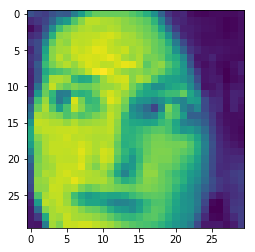

In [38]:
plt.imshow(new_faces[66][10:40,10:40])

In [10]:
len(new_faces)

256

In [21]:
new_pred_emotions=[]
for gray_image in new_faces:
    #gray_image = gray_image.reshape((48,48))[10:40,10:40]
    gray_image = cv2.resize(gray_image.astype('uint8')[10:40,10:40], emotion_target_size)
    gray_image.astype('float32')
    gray_image = np.squeeze(gray_image)
    gray_image = preprocess_input(gray_image, True)
    gray_image = np.expand_dims(gray_image, 0)
    gray_image = np.expand_dims(gray_image, -1)
    emotion_label_arg = np.argmax(emotion_classifier.predict(gray_image))
    new_pred_emotions.append(emotion_label_arg)

In [22]:
#new_pred_emotions

In [23]:
new_dataset_labels=pd.read_csv('../../data/label.csv',delimiter=',',header=None)

In [24]:
new_dataset_labels = new_dataset_labels.as_matrix()

In [25]:
new_dataset_labels = np.squeeze(new_dataset_labels)

In [26]:
new_dataset_labels[:20]

array(['Angry', 'Surprise', 'Happy', 'Sad', 'Angry', 'Neutral', 'Sad',
       'Angry', 'Happy', 'Surprise', 'Happy', 'Angry', 'Sad', 'Sad',
       'Sad', 'Happy', 'Surprise', 'Fear', 'Fear', 'Sad'], dtype=object)

In [27]:
temp_true_labels=[]
for x in new_dataset_labels:
    if x =='Angry':
        temp_true_labels.append(0)
    elif x == 'Disgust':
        temp_true_labels.append(1)
    elif x == 'Fear':
        temp_true_labels.append(2)
    elif x == 'Happy':
        temp_true_labels.append(3)
    elif x == 'Sad':
        temp_true_labels.append(4)
    elif x =='Surprise':
        temp_true_labels.append(5)
    else:
        temp_true_labels.append(6)

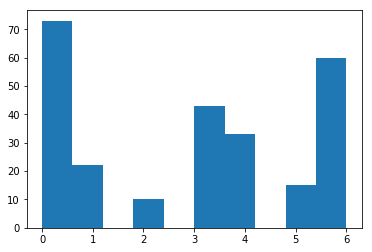

In [28]:
#temp_true_labels
plt.hist(np.array(temp_true_labels))
plt.show()

In [29]:
new_acc = 0
for index, i in enumerate(new_pred_emotions):
    if i == temp_true_labels[index]:
        new_acc = new_acc +1
    else:
        continue


In [30]:
new_acc /= len(new_faces)

In [31]:
print(new_acc) 

0.15234375


In [36]:
# authors model to run the test and the acc is 22.95%
# after change the rest emotions into 'neutral' the accuracy is 22.22%

In [33]:
new_pred_emotions[:10]

[4, 6, 3, 3, 6, 0, 4, 2, 6, 4]

In [34]:
temp_true_labels[:10]

[0, 5, 3, 4, 0, 6, 4, 0, 3, 5]